In [ ]:
include("./mm.jl");

Fact:
let `rd` be the daily rate (not in percentage, but in absolute terms).
then `ry` the yearly rate is given by 
```
ry = (1+rd)^365 - 1
```

and the inverse relationship is 

```
rd = (1+ry)^-365 - 1
```

This is a crazy exponential equation. An yearly rate of `10%` is achived by a daily rate of around `0.03%`

The following graph plots the relation. x axis is daily rate in percentage. y axis is the corresponding yearly rate in percentage

Note also that the maximum negative rate possible is `-100%` at which the initial principal goes to zero.

Note also that from f(0.0%) = 0% to f(0.2%) = 100%, the graph is almost linear, which means that in this region, f(x) = x*365

In [ ]:
#An example of BigFloat, just in case we need it
# setprecision(BigFloat, 2048) do
#     rd = BigFloat("0.0003")
# #     rd = 0.0003
#     ry = (1+rd)^365 - 1
#     println("ry is  ", ry)
#     rd2 = (1+ry)^(1/365) - 1
#     println("rd2 is    ", rd2)
#     @show rd.prec
# end
rd = -0.01:0.00001:0.01
ry = map(i -> (1+i)^365-1, rd)

rs = map(i->i*365, rd)
trace1 = scatter(x=rd.*100, y=ry.*100,
                    mode="lines",
                    name="compunded return")
trace2 = scatter(x=rd.*100, y=rs.*100,
                    mode="lines",
                    name="simple multiplied")
plot([trace1, trace2])

In [ ]:
const d = constructDict()

In [ ]:
function companyComparison(p::Float64)
    nn = (symbol=Vector{String}(undef, 0), prob=Vector{Float64}(undef, 0), label=Vector{String}(undef, 0))
    for key in keys(d)
        sss = key
        pp = prob(d, key, 1, 3*365, p)
        label = get(companyToLabel, key, "")
        push!(nn[:symbol], sss)
        push!(nn[:prob], pp)
        push!(nn[:label], label)
    end
    execute(conn, "BEGIN;")
    execute(conn, "drop table if exists work.company_comparison; ")
    execute(conn, """
    create table work.company_comparison (symbol text, prob float, label text)
    """)
    LibPQ.load!(
        nn,
        conn,
        "INSERT INTO work.company_comparison (symbol, prob, label) VALUES (\$1, \$2, \$3);",
    )

    execute(conn, "COMMIT;")
end
companyComparison(0.15)

In [ ]:
prob(d, "TVSMOTOR",1, 3*365, 0.3 )

In [ ]:
df = table((x=an,))
summarize((mean, std), df)


In [ ]:
function foo()
    sql = """ select symbol from indices i where name = 'nifty-500' """
    result = execute(conn, sql)
    return result |> table
end
df = foo()


In [ ]:
d["^NSEI"]

In [ ]:
death = 100
age = 38
inflationPerMonth = 6/(100*12)
monthlyCost = 100000

months = (death - age)*12
living = monthlyCost * months
println(living)
marriage = 1000000
# education is 100000 per year (present value) starting from 5th year to 5+16 years

education = 16*100000
total = living + marriage + 2*education
println(total)

In [ ]:
df = CSV.read("/home/sharath/Downloads/AdultDataSet.csv")

In [ ]:
df2 = df[shuffle(1:nrow(df))[1:Int(floor((nrow(df)/5)))], :]

In [ ]:
filter(row->row["education"]==" HS-grad" && row["marital-status"]==" Never-married", df)

In [ ]:
typeof(freqtable(df["education"], df["marital-status"]))

In [ ]:
df |> SQLite.load!(sqlite, "adult")

In [ ]:
df = DBInterface.execute(sqlite, "select * from adult") |> DataFrame

In [ ]:
function f(r1::Float64, r2::Float64, x::Float64)
    return ((1+r1)^x) * ((1+r2)^(1-x)) - 1
end
xx  = 0:0.001:0.99
yy = [f(.04, 0.13, x) for x in ran]
plot(xx, yy, hover=string.(xx).*"   ".*string.(yy), size=(1700, 400,))

This is testing an investment strategy. we invest a fixed amount every day for `investDays` days. 
The portfolio is the current list of days that we bought the stocks.
Every day, we also go through our current portfolio. If one of the past day buys have hit more than `rateThreshold`, we sell it. 

After `investDays`, we wait for another `redeemDays` to liquidate any portfolio that remains. After `redeemDays`, we sell whatever is left.
return the amount of money in the wallet after `investDays+redeemDays`

Zerodha has the following transaction fees. 
* charge buy is 1.19 per 1000
* charge sell is 1.04 per 1000
* charge dp is 13.8 per stock per sell per day + 18% GST. since we are dealing with only 1 stock, the charge is 13.8*1.18

````
charge_buy = 1.19/1000 per rupee
charge_sell = 1.04/1000 per rupee
charge_dp = 13.5*1.18 per stock per day
interest_charges = p2(1, fixed_deposit_rate, days_held/365.0) - 1 per rupee

for rupee  p[dayBought]*(1 + charge_buy) =(we get) 1 stock
so for     amount =(we get) amount/(p[dayBought]*(1+charge_buy))

num_stocks = amount/(p[dayBought]*(1+charge_buy))


net_today = num_stock*p[today] - num_stock*p[today]*(charge_sell) - charge_dp
          = num_stock*p[today](1 - charge_sell) - charge_dp

          = amount*p[today](1 - charge_sell) / (p[dayBought]*(1+charge_buy)) - amount*(p2(1, fixed_deposit_rate, days_held/365.0) - 1) - charge_dp
````

In [16]:
function net_today_f(amount::Float64, initialPrice::Float64, nowPrice::Float64, daysHeld::Int)
    charge_buy::Float64 = 1.19/1000
    charge_sell::Float64 = 1.04/1000
    charge_dp::Float64 = 13.5*1.18
    fixed_deposit_rate::Float64 = 5.0/100.0
    return (amount*nowPrice*(1 - charge_sell) / (initialPrice*(1+charge_buy)) - 
                    amount*(p2(1, fixed_deposit_rate, daysHeld/365.0) - 1) - 
                    charge_dp)
end
net_today(1000.0, 10.0, 11.0, 1)

1081.4862349833218

In [ ]:
struct Tls
    ll::FastList{Int}
    prices::Vector{Float64}
    ϕ::Vector{Float64}
    dist::Normal
end
function initializeTls(days) :: Vector{Tls}
    tls = Vector{Tls}(undef, Threads.nthreads())
    Threads.@threads for i in 1:Threads.nthreads()
        tls[Threads.threadid()] = Tls(FastList{Int}(days), Vector{Float64}(undef, days), Vector{Float64}(undef, days), Normal(0, 1))
    end
    return tls
end
tls = initializeTls(10000)

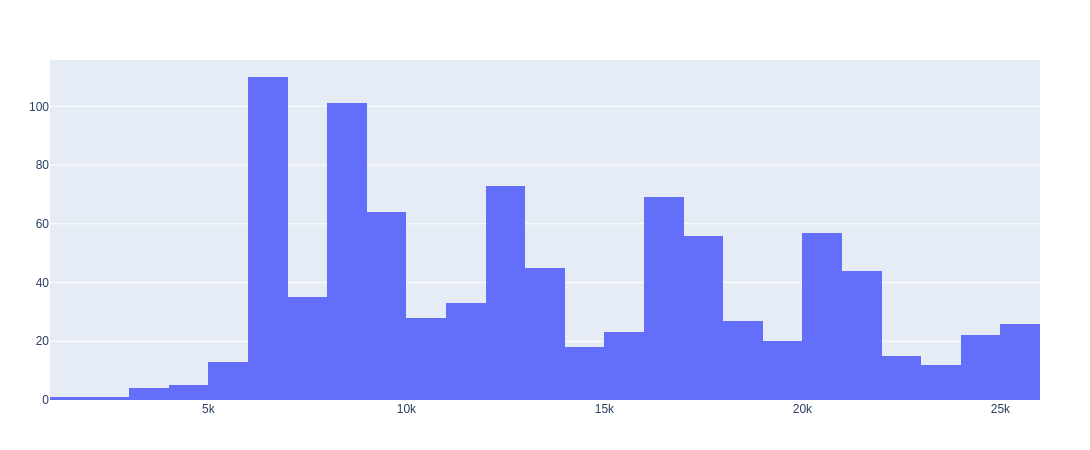

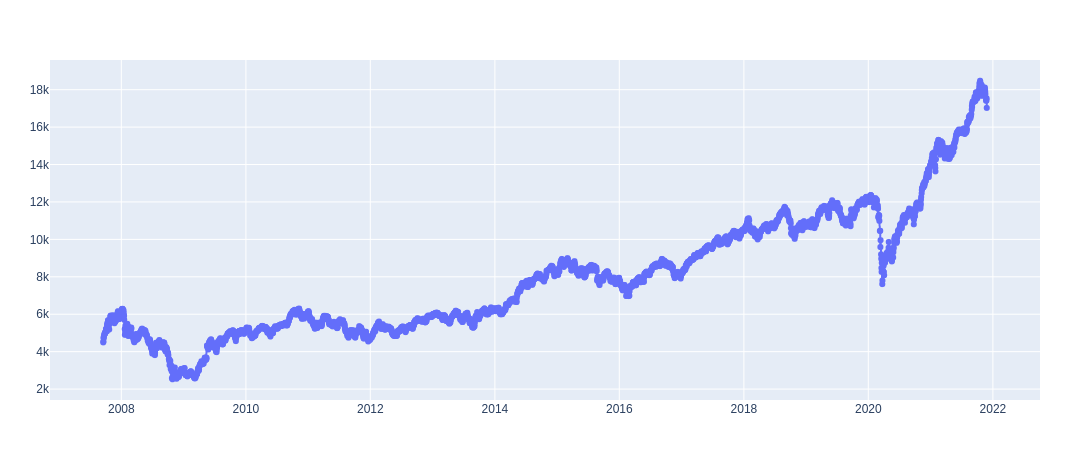

  0.471976 seconds (1.32 M allocations: 85.265 MiB, 0.00% compilation time)


In [57]:

function oneRun(rateThreshold::Float64, investDays::Int, redeemDays::Int, ll::FastList{Int}, 
        tradingDays::AbstractVector{Int}, prices::AbstractVector{Float64})
    days::Int = investDays+redeemDays
    wallet::Float64 = 0.0;
    amount = 1000.0;
    
    daysKept::Int = 0;
    minWallet = 0;
    
    reset!(ll)
    
    for i::Int in 1:days
        for node in ll
            dayBought::Int = node.data
            daysHeld::Int = tradingDays[i] - tradingDays[dayBought]
            net_today::Float64 = net_today_f(amount, prices[dayBought], prices[i], daysHeld)
            rate::Float64 = r(amount, net_today, daysHeld/365.0)
            if rate > rateThreshold || i==days
                wallet += net_today
                daysKept = max(daysKept, daysHeld);
                del(ll, node)
            end
        end
        if i <= investDays
            wallet -= amount
            push!(ll, i)
        end
        minWallet = min(wallet, minWallet)
    end
#     return minWallet
    return wallet
end

# tls is thread local storage
function simulateMulti(tls::Vector{Tls}, d::Dict{String, Point})
    runs::Int = 5000
    investDays = 365*1; redeemDays=365*6; 
    
    days = investDays + redeemDays; 
    results = Vector{Float64}(undef, runs)
      
    rateThreshold::Float64 = .05; μ=meanNifty; σ=stdNifty;
    
    prices=d["^NSEI"].prices;
    tradingDays = d["^NSEI"].intDates;
    
    wallets = Vector{Float64}(undef, 0)
    bad_days = Vector{Int}(undef, 0)
    lk = Threads.SpinLock()
    
    @views Threads.@threads  for start in 1:length(tradingDays) - days - 10
        myTls::Tls = tls[Threads.threadid()]
        pprices = prices[start:end];
        ddates = tradingDays[start:end];

        wallet = oneRun(rateThreshold, investDays, redeemDays, myTls.ll, ddates, pprices);
        lock(lk) do
            push!(wallets, wallet);
            if wallet < 0
                push!(bad_days, start)
            end
        end
    end
#     sort!(negativeDays)
#     println(negativeDays)
#     y = nquantile(wallets, 100)
#     x = collect(1:101)
#     doplot(x, y)
    display( plot([histogram(x=wallets)]))
    dates, prices, intDates = d["^NSEI"].dates, d["^NSEI"].prices, d["^NSEI"].intDates
    trace1 = scatter(x=dates, y=prices,
                        mode="lines+markers",
                        name="nifty 50")
    trace2 = scatter(x=dates[bad_days], y=prices[bad_days],
                        mode="markers",
                        name="start times where the returns are negative")
    add = investDays + redeemDays
    trace3 = scatter(x=dates[bad_days.+investDays], y=prices[bad_days.+investDays],
                        mode="markers",
        name="invest time of the start times")
    trace4 = scatter(x=dates[bad_days.+add], y=prices[bad_days.+add],
                        mode="markers",
        name="invest and redeem time of the start times")

    display(plot([trace1, trace2, trace3, trace4]))#     plot(1:101, nquantile(wallets, 100))
#fuck
end
# tls is thread local storage
function simulateWeinerMulti(tls::Vector{Tls})
    runs::Int = 1000
    investDays = 365*3; redeemDays=365; 
    
    days = investDays + redeemDays; 
    results = Vector{Float64}(undef, 0)
    
    
    rateThreshold::Float64 = .4; μ=.1; σ=.3;
    
    prices=Vector{Float64}(undef, days);
    tradingDays = collect(1:days)
    
    lk = Threads.SpinLock()

    Threads.@threads for run::Int in 1:runs
        tid = Threads.threadid()
        myTls = tls[tid]
        brk = false
        weiner(days, μ, σ, myTls.prices, myTls.ϕ, myTls.dist)
        reset!(myTls.ll)
        result = oneRun(rateThreshold, investDays, redeemDays, myTls.ll, tradingDays, myTls.prices)
        lock(lk) do
            push!(results, result)
        end
    end
    display( plot([histogram(x=results)]))
end
# @time simulateWeinerMulti(tls)
@time simulateMulti(tls, d)



The following graph is interesting. the red is the start time where the returns are negative. we can infer that it happened because of the market crash in 2020

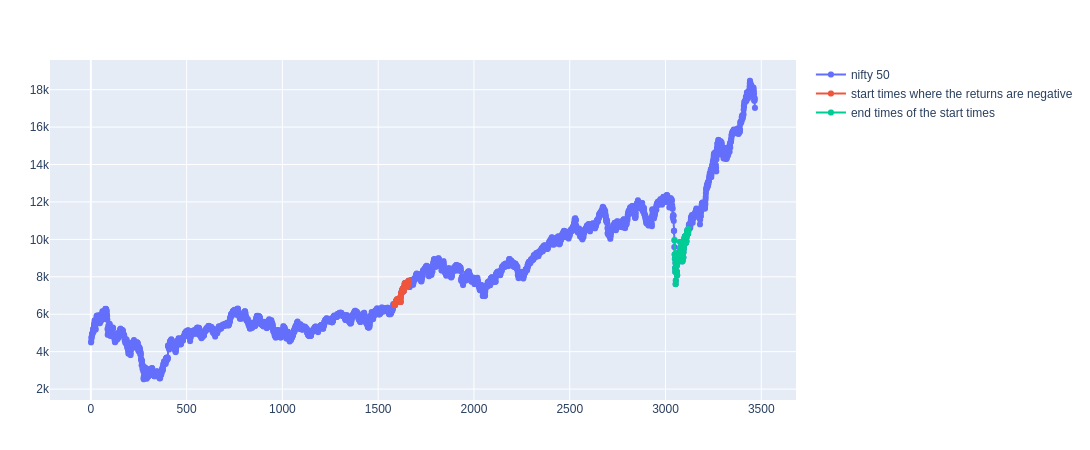

In [7]:
trace1 = scatter(x=1:length(d["^NSEI"].intDates), y=d["^NSEI"].prices,
                    mode="lines+markers",
                    name="nifty 50")
trace2 = scatter(x=1587:1660, y=d["^NSEI"].prices[1587:1660],
                    mode="lines+markers",
                    name="start times where the returns are negative")
add = 4*365
trace3 = scatter(x=(1587+add):(1660+add), y=d["^NSEI"].prices[(1587+add):(1660+add)],
                    mode="lines+markers",
    name="end times of the start times")

plot([trace1, trace2, trace3])

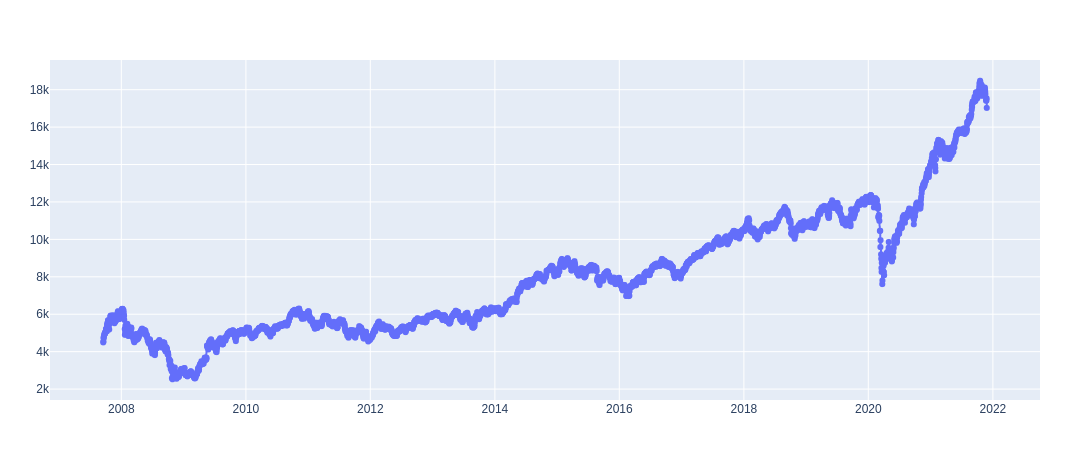

In [8]:
trace1 = scatter(x=d["^NSEI"].dates, y=d["^NSEI"].prices,
                    mode="lines+markers",
                    name="nifty 50")

plot([trace1])

In [ ]:
# input, an array of prices
# output, an array of rates, where rate[i] = price[i]-price[i-1]*100/price[i-1]
function rates(ppp::Vector{Float64})
    diffs = Vector{Float64}(undef, 0)
    for i in 2:length(ppp)
        push!(diffs, (ppp[i]-ppp[i-1])*100/ppp[i-1])
    end
    return diffs
end


In [ ]:
#prints the daily histogram of the stock
function analyse_nse(d::Dict{String, Point})
    p = d["^NSEI"]
    dates, prices, intDates = (p.dates, p.prices, p.intDates)
    diffs = rates(prices)
    #histogram(diffs)
    ptiles = nquantile(diffs, 100)[40:60]
#     plot((1:100)[40:60], ptiles)
    l = length(diffs)
    println("mean is $(mean(diffs))");
    println("stddev is $(std(diffs))")
    println("min date is $(dates[1]), max is $(dates[end])")
#     plot([histogram(x=sort!(diffs)[trunc(Int, l/4):trunc(Int, 3l/4)], nbins=50)])
    plot([histogram(x=diffs, nbins=100)])

end
analyse_nse(d)

# The following graph plots the yearwise mean and std deviation of nifty

In [ ]:
#fuck
function analyse_nse(d::Dict{String, Point})
    p = d["^NSEI"]
    dates, prices, intDates = (p.dates, p.prices, p.intDates)
    hashes = Dict{Int64, Vector{Float64}}()
    for i in 1:length(dates)
        year = Dates.year(dates[i])
        if !haskey(hashes, year)
            hashes[year] = Vector{Float64}(undef, 0)
        end
        push!(hashes[year], prices[i])
    end
    years = Vector{Int}(undef, 0)
    means = Vector{Float64}(undef, 0)
    stds = Vector{Float64}(undef, 0)
    for year in sort!(collect(keys(hashes)))
        ar = filter(x -> !isnan(x), rates(hashes[year]))
        push!(means, mean(ar))
        push!(stds, std(ar))
        push!(years, year)
    end
    println("mean is entire nifty is $(mean(rates(prices))) and std of entire nifty is $(std(rates(prices)))")
    plot(scatter(x=years, y=means,  mode="lines+markers",   error_y=attr(
        type="data",
        array=stds
    )))
end
analyse_nse(d)

In [ ]:
#Prints the biggest losers in the set of stock since now()-days to now()
function losers(d::Dict{String, Point}, stocks::Vector{String}, days::Int)
    rates = Vector{@NamedTuple{stock::String, rate::Float64}}(undef, 0)
    for stock in stocks
        if !haskey(d, stock)
            continue
        end
        a = d[stock].prices[end-days]
        b = d[stock].prices[end]
        rate = (b-a)*100/a
        push!(rates, (stock=stock, rate=rate))
    end
    sort!(rates, by=tup->tup.rate)
    return rates
end
losers(d, labelToCompany["niftysmallcap50"], 45)

In [ ]:
Vector{@NamedTuple{a::Int, b::String}}

# Experimentation on multidimensional array speeds

array iteration speed is about 1 billion per second. insane.

In [ ]:
function test(ar::Array{Int64})
    sum = 0
    for i in 1:1000
        for j in 2:length(ar)
            sum+=ar[j]
#             ar[j]+=ar[j-1]
        end
    end
    return sum
end
time_sum(x) = @time test(x);
time_sum(ar)
println(typeof(ar), size(ar))


# Speeds of DataFrames
fucking dataframes is not type stable so it is 100-1000x slower than array iteration and allocates a large amount of memory

There are several table like structures in julia (mostly third parties, several of them seem to be overlapping a lot in functionality)
The best one seems to be IndexedTable. it is type stable. It is implementated as a NamedTuple of vectors but acts like a vector of NamedTuples.
Of course, the fastest and most native is just NamedTuple. But it seems like a NamedTuple (and also IndexedTable) with many columns might stress the compiler (havent tested it)

IndexedTable constructor *copies* the data from the NamedTuple constructor param to create the new IndexedTable. However, invoking `IndexedTable.columns ` returns a NamedTuple *view* of the IndexedTable which is perfect for arbitrary iteration and modifications.

btw, the nomenclature is really fucked up.
- [Julia Data](https://github.com/JuliaDatahttps://github.com/JuliaData) is the name for all built in table like structures in Julia. They all seem to respect the Tables.jl interface
- [JuliaDB](https://juliadata.github.io/JuliaDB.jl/latest/https://juliadata.github.io/JuliaDB.jl/latest/) is one particular table like structure in Julia Data. It is built on `IndexedTables` (seems like both are synonymous). This is the best since it is type stable
- [DataFrames](https://github.com/JuliaData/DataFrames.jlhttps://github.com/JuliaData/DataFrames.jl) is a slow and fucked up implementation in Julia Data. It is feature rich but fucking slow
- [Julia Databases](https://juliadatabases.github.io/https://juliadatabases.github.io/) collects various drivers for different databases like Mysql, postgres, sqlite. seems like all of them can stream to a tables.jl constructor

A good summary of all the shit can be found [here](https://www.juliabloggers.com/a-tour-of-the-data-ecosystem-in-julia/https://www.juliabloggers.com/a-tour-of-the-data-ecosystem-in-julia/) from the author of CSV.jl

In [ ]:
function testDataFrame(df::DataFrame)
    ar::Array{Int64} = df.a
    sum = 0
    for i::Int64 in 1:1000
        for j in 1:length(ar)
            sum+=ar[j]
        end
    end
    return sum
end


# println(typeof(df))
time_sum(df) = @time testDataFrame(df);
time_sum(df)


In [ ]:
sql = """select symbol , array_agg(name)as names from indices i group by symbol """
result = execute(conn, sql)
println(show_supertypes(typeof(result)))
df = result |> JuliaDB.table

l = length(df)
order = splt("""
nifty-50
nifty-next-50
nifty-midcap-50
nifty-midcap-100
nifty-midcap-150
niftysmallcap50
nifty-smallcap-100
nifty-smallcap-250

    """)
println(order)
companyToLabel = Dict{String, String}()
labelToCompany = Dict{String, Vector{String}}()
for i in 1:l
    company = df[i].symbol
    names = splt(df[i].names[2:end-1], ",")
    for label in order
        if findfirst(x->x==label, names) != nothing
            companyToLabel[company] = label
            if !haskey(labelToCompany, label)
                labelToCompany[label] = Vector{String}(undef, 0)
            end
            push!(labelToCompany[label], company)
            @goto label
        end
    end
    companyToLabel[company] = names[1]
    @label label
end

In [ ]:
lbl = "niftysmallcap50"
print(labelToCompany[lbl])
print(length(labelToCompany[lbl]))

In [ ]:
data = table((symbol=Vector{String}(undef, 0), company=Vector{String}(undef, 0), prob=Vector{Float64}(undef, 0), label=Vector{String}(undef, 0)))


In [ ]:
show_supertypes(typeof(rows(data)))

In [ ]:
 sa = StructArray([1+im, 3-2im])

In [ ]:
tt = table(1:10, randn(10), rand(Bool, 10); names = [:x, :y, :z])


In [ ]:
push!(rows(tt), (x=1, y=1.1, z=true))

In [ ]:
select(tt, :x)

# Threads

In [ ]:
show_supertypes(typeof(view(Vector{Int}(undef, 10), 1:3)))

In [ ]:
for m in methods(oneRun)
    Base.delete_method(m)
end

In [ ]:
function monteCarlo()
    runs::Int = 10000
    days::Int = 1000
    s::Vector{Float64} = Vector{Float64}(undef, days)
    ϕ::Vector{Float64} = Vector{Float64}(undef, days)
    dist::Normal = Normal(0, 1)
    μ::Float64, σ::Float64 = 10.0/100, 30.0/100
    last::Vector{Float64} = Vector{Float64}(undef, runs)
    for run::Int in 1:runs
        weiner(days, μ, σ, s, ϕ, dist)
        last[run] = s[end]
    end
    plot([histogram(x=last)])
end
monteCarlo()

this produces a csv with the following columsn:
symbol, mean, stdev, 0%ile, 5%ile, ... 100%ile
the values are daily percent changes
we can observe the following:

* the average is always around 50%ile
* according to statistics theory, 1 stdev = 68%. If we consider the positive half, this is 34%. so the value of 1 stdev is expected to occur near 50+34 =85%ile. and this is indeed the case.

In [ ]:
#this produces a csv with the following columsn:
#symbol, mean, stdev, 0%ile, 5%ile, ... 100%ile
#the values are daily percent changes
#days: the rate calculated for last how many days? 
function means(d::Dict{String, Point}, days::Int ,csv::String)
#     sql = """select distinct symbol from indices i where name like '%nifty-50%' and name not like '%nifty-500%' """
    sql = """select distinct symbol from indices i """
#     sql = """select distinct symbol from indices i where name like '%nifty-next-50%' """
    result = execute(conn, sql)
    df = result |> JuliaDB.table

    # percentiles
    ptiles = OrderedDict{Symbol, Vector{Float64}}()
    num_ptiles = 20
    for i in 1:(num_ptiles+1)
        ptiles[Symbol(string(trunc(Int64, 100*i/num_ptiles)))] = Vector{Float64}(undef, 0)
    end

    # means
    mns = Vector{Float64}(undef, 0)

    symbols = Vector{String}(undef, 0)
    # standard deviations
    sts = Vector{Float64}(undef, 0)

    for i in 1:length(df)
        if !haskey(d, df[i].symbol)
            println("dict does not have key for $(df[i].symbol)")
            continue
        end

        p = d[df[i].symbol]
        dates, prices, intDates = (p.dates, p.prices, p.intDates)
        diffs = Vector{Float64}(undef, 0)
        if length(intDates) < days + 2
            continue
        end
        for i in days+1:length(intDates)
#             if intDates[i] == intDates[i-1] + 1
#                 rate = r(prices[i-1], prices[i], 1)*100
#                 push!(diffs, rate)
#             end
            rate = (prices[i]-prices[i-days])*100/prices[i]
            push!(diffs, rate)
        end
        if length(diffs) == 0
            println("$(df[i].symbol) has no diffs")
            continue
        end
        push!(symbols, df[i].symbol)
        push!(mns, round(mean(diffs), digits=2))
        push!(sts, round(std(diffs), digits=2))
        quantiles = nquantile(diffs, num_ptiles)
        for j in 1:length(quantiles)
            push!(ptiles[Symbol(string(trunc(Int64, 100*j/num_ptiles)))], round(quantiles[j], digits=2))
        end
    end
    # println("$(size(select(df, :symbol))) and $(size(mns))")
    df = JuliaDB.table((symbol=symbols, mean=mns, stdev=sts))
    df = insertcols(df, 4, ptiles)
    CSV.write(csv, df)
end
means(d, 45, "nifty_50_last_45_days.csv")

In [ ]:
methods(JuliaDB.rename)

In [ ]:
N = 100
random_x = range(0, stop=1, length=N)
random_y0 = randn(N) .+ 5
random_y1 = randn(N)
random_y2 = randn(N) .- 5

# Create traces
trace1 = scatter(x=random_x, y=random_y0,
                    mode="lines",
                    name="lines")
trace2 = scatter(x=random_x, y=random_y1,
                    mode="lines+markers",
                    name="lines+markers")
trace3 = scatter(x=random_x, y=random_y2,
                    mode="markers", name="markers")

plot([trace1, trace2, trace3])

In [ ]:
methods(JuliaDB.table)

# Experimenting with julia dates

In [ ]:
date1 = DateTime(2022, 01, 01)
date2 = DateTime(2022, 01, 13)
println("date1 is $(date1), date2 is $(date2)")
println("year is $(Dates.year(date1)), type is $(typeof(Dates.year(date1)))")

# Experiment with CDF


In [ ]:
# this is a normal distribution with stdev=1
# cdf(dist, 1) is the probability of entire left half + normal distribution before x=1
# for normal distribution, 68% lies   thin 1 standard deviation. so cdf(dist, 1) = 50% (left half) + 1/2 * 68 (right half) = 84%
dist = Normal(0, 1)
cdf(dist, 1)


# Experiment with error bars

In [ ]:
plot(scatter(
    x=[1, 2, 3, 4],
    y=[2, 1, 3, 4],
    mode="markers",
    error_y=attr(
        type="data",
        array=[1,2,3,4]
    )
))


In [43]:
dates, prices, intDates = d["^NSEI"].dates, d["^NSEI"].prices, d["^NSEI"].intDates
convert(Dates.Day, dates[365*4+500] - dates[500]).value/365

6.002739726027397